In [1]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from IPython.display import clear_output

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\Big_statistics\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [2]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]

# 1) Определяем параметры
problem = {
    'num_vars': 5,
    'names': ['F', 'fs_mult', 'duration_T','phase','window_T'],
    'bounds': [
        [300e3, 500e3],     # F
        [3, 100],            # fs_mult
        [10, 200],           # duration_T
        [1,179],             # phase
        [10,100]             # window in T
    ]
}

# 2) Генерация траекторий
param_values = morris_sampler.sample(problem, N=500, num_levels=10)
i=0
from tqdm import tqdm
Y_mass = []
for i in range(0, len(phase_methods), 1):
    Y = []

    # tqdm оборачивает param_values и показывает прогресс
    for j, p in enumerate(tqdm(param_values, desc=f"Метод {phase_methods[i].__name__}", unit=" шага")):
        F, fs_mult, duration_T, phase_real, window_T = p
        if (window_T + 5 >= duration_T):
            window_T = duration_T - 3
        duration = duration_T / F

        t = np.arange(0, duration, 1 / (fs_mult * F))
        U = md.generate_sin(t, F, 2)
        I = md.generate_sin(t, F, 2, phase_real)

        time, phase_mes = phase_methods[i](t, U, I, F, int(window_T))
        phase_kde = md.get_kde_mode(phase_mes)
        phase_error = abs(phase_kde) - abs(phase_real)
        Y.append(abs(phase_error))

    Y = np.array(Y)
    Y_mass.append(Y)
    

Метод get_phase_hilbert:   2%|▏         | 54/3000 [00:03<03:04, 15.94 шага/s]


KeyboardInterrupt: 

In [ ]:
# Очистка названий
def clean_name(func):
    return func.__name__.replace("get_phase_", "").replace("get_phase", "")

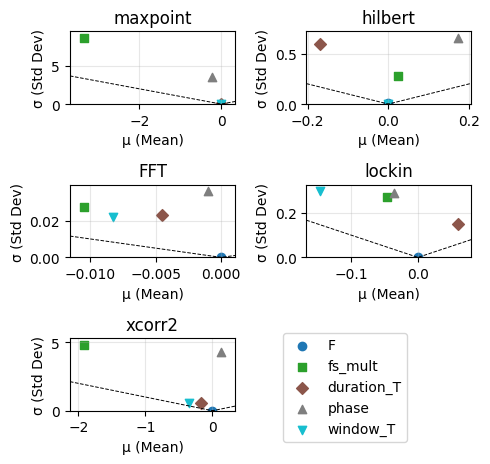

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

method_names = [m.__name__ for m in phase_methods]
param_names = problem['names']

# Цвета и маркеры
colors = plt.cm.tab10(np.linspace(0, 1, len(param_names)))
markers = ['o', 's', 'D', '^', 'v', '*', 'P', 'X']

fig, axes = plt.subplots(3, 2, figsize=(5, 5))
axes = axes.flatten()

# Список для хранения "фейковых" точек (для легенды)
legend_handles = []

for i, method in enumerate(phase_methods):
    Si = morris_analyzer.analyze(problem, param_values, Y_mass[i])
    mu = Si['mu']
    sigma = Si['sigma']

    ax = axes[i]

    for j, name in enumerate(param_names):
        sc = ax.scatter(mu[j], sigma[j], color=colors[j], marker=markers[j % len(markers)])
        # Только при первом методе наполняем legend_handles
        if i == 0:
            legend_handles.append(sc)

        # Границы оси X основаны только на му
    mu_min, mu_max = mu.min(), mu.max()
    pad = (mu_max - mu_min) * 0.1 if mu_max != mu_min else 0.1  # запас
  
    lim_x = [mu_min - pad, mu_max + pad]

    # Границы оси Y (σ >= 0)
    sigma_max = sigma.max()
    ax.set_ylim([0, sigma_max * 1.1])

    # Диагональные линии
    x_line = np.linspace(lim_x[0], lim_x[1], 100)
    ax.plot(x_line, x_line, '--', linewidth=0.7, color='k')
    ax.plot(x_line, -x_line, '--', linewidth=0.7, color='k')

    ax.set_xlim(lim_x)

    ax.set_ylim([0, sigma.max() * 1.1])

    ax.set_title(clean_name(phase_methods[i]), fontsize=12)
    ax.set_xlabel('μ (Mean)', fontsize=10)
    ax.set_ylabel('σ (Std Dev)', fontsize=10)
    ax.grid(True, alpha=0.3)

# Удаляем лишнюю пустую ось (так как графиков 5, а мест 6)
for j in range(len(phase_methods), len(axes)):
    fig.delaxes(axes[j])

# Общая легенда
fig.legend(
    legend_handles, param_names,
    loc='lower center',         # перенести вниз
    ncol=1,                     # два ряда (5 параметров > 3 => автоматически сделает новый ряд)
    bbox_to_anchor=(0.7, 0.04),  # смещение ниже графиков
    fontsize=10
)

#fig.suptitle('Диаграмма чувствительности (Метод Морриса)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


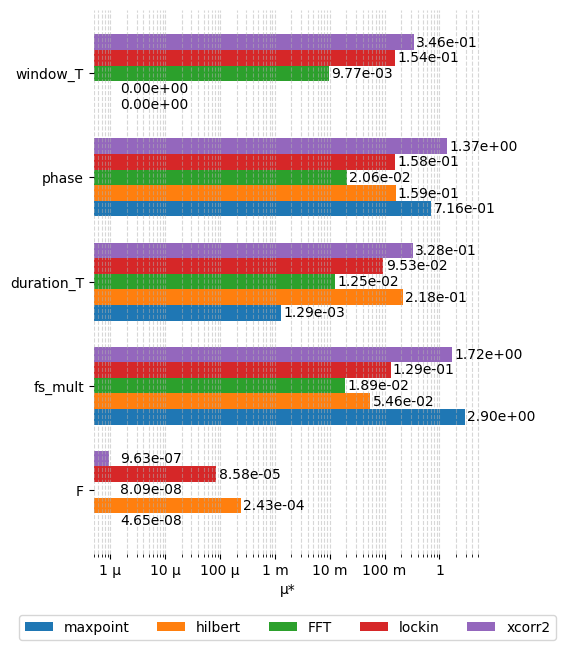

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter


method_names = [clean_name(m) for m in phase_methods]
param_names = problem['names']

# Вычисляем mu*
mu_stars = []
for k in range(len(phase_methods)):
    Si = morris_analyzer.analyze(problem, param_values, Y_mass[k], print_to_console=False)
    mu_stars.append(Si['mu_star'])
mu_stars = np.array(mu_stars)

# --- Построение графика ---
fig, ax = plt.subplots(figsize=(5, 8))
y = np.arange(len(param_names))
height = 0.15

# Убираем все рамки
for spine in ax.spines.values():
    spine.set_visible(False)

min_val = np.max([np.min(mu_stars), 1e-6])
# Рисуем бары
for i in range(len(method_names)):
    bar_positions = y + i * height
    bars = ax.barh(bar_positions, mu_stars[i], height, label=method_names[i])

    for bar in bars:
        value = bar.get_width()
        offset = 1.1  # множитель для смещения справа

        # 📌 Гарантированно правее оси Y
        if value <= min_val:
            text_x = min_val * 1.5
        else:
            text_x = value * offset

        ax.text(
            text_x,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.2e}",
            va='center'
        )

# Оформление
ax.set_yticks(y + height * (len(method_names)-1) / 2)
ax.set_yticklabels(param_names)
ax.set_xlabel('μ*')

# Логарифмическая шкала
ax.set_xscale('log')
ax.grid(axis='x', linestyle='--', alpha=0.5, which='both')

# Правильный формат оси
ax.xaxis.set_major_formatter(EngFormatter(sep=" "))

max_val = np.max(mu_stars) * 2
min_val = np.max([np.min(mu_stars), 1e-6]) / 2  # чтобы не уходило в ноль лог-шкалы
ax.set_xlim(min_val, max_val)

# 📦 Сдвигаем легенду вниз, НЕ используя tight_layout
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(method_names))

# Увеличиваем нижнее поле вручную
plt.subplots_adjust(bottom=0.2)

plt.show()


## Отдельный метод для тестов

In [7]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer

phase_method=md.get_phase_xcorr2
phase_methods = [
    md.get_phase_maxpoint_diff
]


# 1) Определяем параметры
problem = {
    'num_vars': 5,
    'names': ['F', 'fs_mult', 'duration_T','phase','window_T'],
    'bounds': [
        [300e3, 500e3],     # F
        [3, 100],            # fs_mult
        [10, 200],           # duration_T
        [1,179],             # phase
        [10,100]             # window in T
    ]
}

Y = []
# 2) Генерация траекторий
param_values = morris_sampler.sample(problem, N=2000, num_levels=10)
i=0
for p in param_values:
    i+=1
    print(i)
    F, fs_mult, duration_T, phase_real,window_T  = p
    if (window_T+5>=duration_T):
        window_T=duration_T-3
    duration=duration_T/F

    t = np.arange(0, duration, 1/(fs_mult*F))
    U = md.generate_sin(t,F,2)
    I = md.generate_sin(t,F,2,phase_real)
    # --- Добавление шума ---

    time, phase_mes=phase_method(t,U,I,F,int(window_T))
    print(p)
    phase_kde=md.get_kde_mode(phase_mes)
    phase_error=abs(phase_kde) - abs(phase_real)
    Y.append(abs(phase_error))
    

Y=np.array(Y)

AttributeError: module 'model' has no attribute 'get_phase_maxpoint_diff'

In [ ]:
Si = morris_analyzer.analyze(problem, param_values, Y, print_to_console=True)

                  mu   mu_star     sigma  mu_star_conf
F           0.000001  0.000003  0.000037      0.000002
fs_mult    -1.745108  1.899192  4.542993      0.187350
duration_T -0.201813  0.326410  0.757021      0.029701
phase       0.033165  1.403169  3.636741      0.148760
window_T   -0.362842  0.366442  0.535016      0.022850
